In [1]:
import cv2
import numpy as np
import operator
import os
import tensorflow as tf
import logging
import matplotlib.pyplot as plt

In [2]:
# To Disable warnings when loading model 

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
# Loading Model

model = tf.keras.models.load_model('../model/Conv2D_Digit_Recog.model')

In [128]:
# Loading sudoku grid

grid = cv2.imread('../sample_images_sudoku_grid/grid_2.png')
grid = cv2.resize(grid, (360, 360))

In [5]:
gray = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 12)
inv = cv2.bitwise_not(thresh)

In [6]:
# Finding contours and selecting biggest contour as our sudoku grid

contours, hierarchy = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

polygon = contours[0]

In [7]:
# Detecting corner points of the board

bottom_right, ret = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
top_left, ret = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
bottom_left, ret = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
top_right, ret = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

In [ ]:
# Warping image

pts1 = np.float32([polygon[top_left][0], polygon[top_right][0], polygon[bottom_left][0], polygon[bottom_right][0]])
pts2 = np.float32([[0, 0], [360, 0], [0, 360], [360, 360]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
result = cv2.warpPerspective(inv, matrix, (360, 360))

In [9]:
# Splitting image in 9x9 grid

squares = []
side = grid.shape[:1]
side = int(side[0]/9)
for j in range(9):
    for i in range(9):
        p1 = (i * side, j * side)
        p2 = ((i + 1) * side, (j + 1) * side)
        squares.append((p1, p2))

In [10]:
# Loading zero because to add zero for cell which do not contain any number i.e unsolved cells

zero = cv2.imread('../custom_images/zero.jpg', cv2.IMREAD_GRAYSCALE)

In [11]:
images = []
kernel = np.ones((3, 3), np.uint8)

In [12]:
# Cropping each 9x9 cells from either end to remove edge of sudoku grid

for i in range(0, 81):
    img = result[squares[i][0][1]:squares[i][1][1], squares[i][0][0]:squares[i][1][0]]
    img = cv2.resize(img, (50, 50))
    img = img[5:45, 5:45]
    images.append(img)
    

In [13]:
images = np.array(images, np.uint8)

In [14]:
x_test = []

In [15]:
# Evaluating percentange of white pixel in individual 9x9 cell to detect wheter number is zero or non-zero, if perentage of 
# white pixel is less than certain threshold then it is assumed as zero, and replacing with zero image which was prior loaded

for x in range(0, 81):
    img = images[x]
    rows, cols = img.shape
    ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    ctr = 0

    for i in range(rows):
        for j in range(cols):
            k = thresh[i, j]
            if k == 255:
                ctr = ctr + 1

    per = (ctr/(rows*cols))*100

    if per < 5:
        thresh = zero
        x_test.append(thresh)
    else:
        x_test.append(thresh)

In [24]:
x_test = np.array(x_test, np.uint8)

In [25]:
num = []

In [26]:
# Predicting individual images through pre-loaded trained model

for i in range(0, 81):
    img = x_test[i]
    img = cv2.resize(img, (28, 28))
    test = img.reshape(-1, 28, 28, 1)
    
    prediction = model.predict(test)
    num.append(np.argmax(prediction))

In [38]:
row = []
row_1 = []
row_2 = []
row_3 = []
row_4 = []
row_5 = []
row_6 = []
row_7 = []
row_8 = []
row_9 = []

In [39]:
# Forming 9x9 Grid

for i in range(0, 9):
    row_1.append(num[i])
row.append(row_1)

for i in range(9, 18):
    row_2.append(num[i])
row.append(row_2)

for i in range(18, 27):
    row_3.append(num[i])
row.append(row_3)

for i in range(27, 36):
    row_4.append(num[i])
row.append(row_4)

for i in range(36, 45):
    row_5.append(num[i])
row.append(row_5)

for i in range(45, 54):
    row_6.append(num[i])
row.append(row_6)

for i in range(54, 63):
    row_7.append(num[i])
row.append(row_7)

for i in range(63, 72):
    row_8.append(num[i])
row.append(row_8)

for i in range(72, 81):
    row_9.append(num[i])
row.append(row_9)

In [40]:
def print_board(board):
    for i in range(len(board)):
        if (i % 3 == 0 and i != 0):
            print("-------------------------")

        for j in range(len(board[0])):
            if (j % 3 == 0 and j != 0):
                print(" | ", end="")

            if j == 8:
                print(board[i][j])
            else:
                print(str(board[i][j]) + " ", end="")

5 3 0  | 0 7 0  | 0 0 0
6 0 0  | 1 9 5  | 0 0 0
0 9 8  | 0 0 0  | 0 6 0
- - - - - - - - - - - - - 
8 0 0  | 0 6 0  | 0 0 3
4 0 0  | 8 0 3  | 0 0 1
7 0 0  | 0 2 0  | 0 0 6
- - - - - - - - - - - - - 
0 6 0  | 0 0 0  | 2 8 0
0 0 0  | 4 1 9  | 0 0 5
0 0 0  | 0 8 0  | 0 7 9


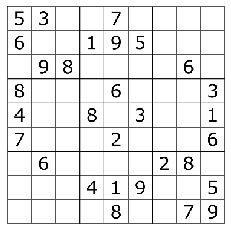

In [47]:
print_board(row)
plt.imshow(grid)
plt.axis("off")
plt.show()

In [52]:
#Solving 9x9 Grid using Backtracking

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)
    return None
board = row

def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False


def valid(bo, num, pos):
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False

    
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)

    return None

In [53]:
solve(row)
print_board(row)

5 3 4  | 6 7 8  | 9 1 2
6 7 2  | 1 9 5  | 3 4 8
1 9 8  | 3 4 2  | 5 6 7
- - - - - - - - - - - - - 
8 5 9  | 7 6 1  | 4 2 3
4 2 6  | 8 5 3  | 7 9 1
7 1 3  | 9 2 4  | 8 5 6
- - - - - - - - - - - - - 
9 6 1  | 5 3 7  | 2 8 4
2 8 7  | 4 1 9  | 6 3 5
3 4 5  | 2 8 6  | 1 7 9


In [170]:
def check_for_zero(x):
    img = images[x]
    rows, cols = img.shape
    ret, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    ctr = 0

    for i in range(rows):
        for j in range(cols):
            k = thresh[i, j]
            if k == 255:
                ctr = ctr + 1

    per = (ctr/(rows*cols))*100
    
    if per<5:
        return True
    else:
        return False


In [171]:
num_to_grid = []
for r in row:
    for i in r:
        num_to_grid.append(i)

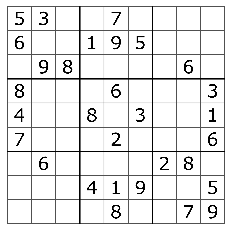

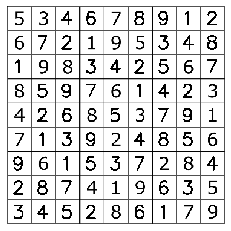

In [186]:
# Checking for unsolved cells i.e. whether cells is zero or non-zero and if cell is zero replacing it with appropriate number.

grid_unsolved = cv2.imread('../sample_images_sudoku_grid/grid_2.png')
grid = cv2.resize(grid_unsolved, (360, 360))
grid = cv2.imread('../sample_images_sudoku_grid/grid_2.png')
grid = cv2.resize(grid, (360, 360))

for i in range(0, 81):
    b = check_for_zero(i)
    
    if b is True:
        p1 = squares[i][0]
        p2 = squares[i][1]
        
        mid_x = int((p1[0] + p2[0])/2)-12
        mid_y = int((p1[1] + p2[1])/2)+10
        
        cv2.putText(grid, str(num_to_grid[i]), (mid_x, mid_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

plt.imshow(grid_unsolved)
plt.axis("off")
plt.show()

plt.imshow(grid)
plt.axis("off")
plt.show()